## Author : Si Dan HO, Antoine Jacquet, Mickael Masumbuko

# Calibration et valorisation sous le modèle d'Heston

In [1]:
import time
import datetime as dt
import pandas as pd
#from pandas_datareader import data as pdr
import numpy as np
import math
import scipy.stats as st
import scipy as sp
import scipy.optimize as spop
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm 
import pylab as py
#from tabulate import tabulate
#import QuantLib as ql
import scipy.integrate
import cmath
from tqdm import tqdm_notebook as tq


Il a été vu précédemment que le modèle de Black Scholes, bien que simple et intuitif à mettre en place pour la valorisation des options, souffrait de plusieurs limites, dont la principale fut l'hypothèse de la volatilité constante. En effet, il a été constaté que la volatilité implicite d'une option dépend en réalité du strike et de la maturité de l'option, ce qui permet d'observer le phénomène de Smile de volatilité, dont le modèle ne peut capturer et donc ne peut reproduire l'ensemble des prix d'options observés sur le marché. 

C'est pourquoi d'autres modèles plus avancés telle que les modèles de volatilité locale où la volatilité du sous-jacent (qui est une action) est une fonction déterministe du prix du sous jacent ainsi que du temps, et qui permet donc, tout en gardant l'hypothèse de complétude des marchés, de reproduire le plus fidèlement possible le phénomène du Smile de volatilité par une calibration de cette volatilité via la formule de Dupire ou en utilisant le modèle CEV par exemple. 

Cependant, les dynamiques de volatilité prévue par ce type de modèle ne sont en réalités pas en adéquation avec ceux observés sur le marché. Ce problème peut être résolu via l'introduction de modèles à volatilité stochastique, où la volatilité du sous-jacent suit explicitement une propre dynamique stochastique, qui peut être corrélée avec celle qui est propre au sous-jacent. Ces modèles permettent ainsi non seulement de reproduire et expliquer le Smile de volatilité, mais aussi de modéliser le plus justement et donc le plus précisément possible la dynamique de la volatilité implicite de l'option.

L'inconvénient des modèles à volatilité stochastique est l'abandon de l'hypothèse de complétude des marchés du fait de l'introduction d'une nouvelle dynamique, celle de la volatilité du sous-jacent, appliquant donc l'ajout du facteur de risque lié à la volatilité qui ne peut être couvert par une stratégie de portefeuille composé uniquement d'actions, qui ne se permet de se couvrir qu'en delta. Cela pourrait être résolu en introduisant un nouvel instrument tel que le VIX ou bien des variance-forwards, permettant ainsi une couverture en vega.

Quelques uns des modèles à volatilité stochastique les plus célèbres sont :
- le modèle de Heston
- le modèle SABR
- le modèle de Bates
- le modèle à cadre Markovien
- le modèle de Taylor

L'objectif de ce projet est de calibrer le modèle de Heston.

Le modèle de Heston est un modèle de volatilité stochastique, stipulant que la dynamique du prix du sous-jacent $S$ et de sa volatilité $\sigma$ s'exprime de la manière suivante, sous la probabilité risque neutre $\mathbb{Q}$ :

$$
\left\{
    \begin{array}{lll}
    dS_t = S_t(r dt + \sqrt{\sigma_t} dW_t^1) \\
    d\sigma_t = \kappa(\theta - \sigma_t) dt + \xi \sqrt{\sigma_t} dW_t^2 \\
    d<W_t^1, W_t^2> = \rho dt
    \end{array}
\right.
$$

avec $W_t^1$ et $W_t^1$ des $\mathbb{Q}$ mouvements browniens.

Il est ainsi aisé de constater que la volatilité $\sigma$ suit un modèle de taux d'intéret à court terme nommé Cox-Ingersoll-Ross (CIR) permettant ainsi à cette volatilité stochastique un retour à la moyenne positive et à long terme $\theta$ selon le paramètre $\kappa$. Le terme $\sqrt{\sigma_t}$ permet de s'assurer que la volatilité reste positive à tout instant. Il faut enfin noter que le terme $\xi$ est la volatilité de la volatilité.

# Sommaire 

- Calcul du prix de Call sous le modèle de Heston
    - Calcul par la formule analytique de Heston
    - Calcul par simulation Monte Carlo
- Estimation de la trajectoire de la volatilité sous le modèle d'Heston
    - Estimation par filtrage Bootstrap
- Calibration des paramètres du modèle de Heston
    - Calibration sur les données marché du S&P500
        - Chargement et traitement des données
        - Calibration des paramètres selon les données
    - Calcul de la volatilité implicite des Calls sous le modèle
- pricing des Variance Swap sur S&P500 sous le modèle d'Heston
    - Application numérique

## Calcul du prix de Call sous le modèle de Heston

### Calcul par la formule analytique de Heston

La grande avantage du modèle de Heston est l'existence d'une formule fermée pour le prix des options européennes Vanille. En effet, le prix $C_t$ d'un Call de sous-jacent $S$ et de payoff $(S_T- K)_{+}$ sous le modèle de Heston est exprimée de cette manière, en notant $\tau = T-t$ qui est le ténor du Call à l'instant $t$:

$$
C_t = C(t, S, \sigma) = S_tP_1 - Ke^{-r\tau}P_2
$$

où : 

$$
P_j = \frac{1}{2} + \frac{1}{\pi} \int_{0}^{\infty} Re[\frac{e^{-i\Phi ln(K)}f_j(t, x, \sigma, \Phi)}{i\Phi}]d\Phi
$$

avec : $x = ln(S)$, $f_j(t, x, \sigma,\phi) = exp(C_j(\tau, \phi) + D_j(\tau, \phi)\sigma + i\phi x)$,

Puis :

$$
C_j(\tau, \Phi) = r\Phi i \tau+ \frac{a}{\xi^2}[(b_j- \rho \xi \Phi + d)\tau- 2ln(\frac{1-ge^{d\tau}}{1-g})]
$$

$$
D_j(\tau, \Phi) = \frac{b_j - \rho \xi\Phi i + d}{\xi^2}[\frac{1-e^{d\tau}}{1-ge^{d\tau}}]
$$,

avec : $g = \frac{b_j - \rho \xi \Phi i +d}{b_j - \rho \xi \Phi i - d}$,  $d = \sqrt{(\rho \xi \Phi i -b_j)^2 - \xi^2(2u_j \Phi i - \Phi^2)}$,

et $a = \kappa \theta$, $u_1 = \frac{1}{2}$, $u_2 = -\frac{1}{2}$, $b_1 = \kappa + \lambda - \rho \xi$, $b_2 = \kappa + \lambda$.

La démonstration de cette formule fermée, inspirée du raisonnement effectué dans le cadre de celle de Black Scholes, a été effectuée et se trouve en annexe. L'implémentation de la formule fermée pour calculer le prix actuel d'un Call, c'est à dire à l'instant $0$, s'effectue comme suit :

In [12]:
import cmath

# Déclaration du nombre imaginaire i
i=complex(0,1)

# Implémentation de la formule de Heston pour un Call
def HestonCallClosedForm(kappa, theta, xi, rho, v0, r, tau, S0, K):
    def PIntegrand(u, kappa, theta, xi, rho, v0, r, tau, S0, K, j):
            F = S0*math.exp(r*tau)
            x = cmath.log(F/K)
            a = kappa * theta
            
            if j == 1 :
                b = kappa - rho*xi
                alpha = - u**2/2 - u/2 * i + i * u
                beta = kappa - rho * xi - rho *xi * i * u
            else:
                b = kappa
                alpha = - u**2/2 - u/2 * i
                beta = kappa - rho*xi*i*u
            
            gamma = xi**2/2
            d = cmath.sqrt(beta**2 - 4*alpha*gamma)
            rplus = (beta + d)/(2*gamma)
            rminus = (beta - d)/(2*gamma)
            g = rminus/rplus
            
            D = rminus*(1 - cmath.exp(-d*tau))/(1-g*cmath.exp(-d*tau))
            C = kappa*(rminus * tau - 2/(xi**2) * cmath.log((1-g*cmath.exp(-d*tau))/(1-g)))
            
            top = cmath.exp(C*theta + D*v0 + i*u*x)
            bottom = (i*u)
            return (top/bottom).real

    def P(kappa, theta, xi, rho, v0, r, tau, S0, K, j):
            value = scipy.integrate.quad(PIntegrand, 0, np.inf, args=(kappa, theta, xi, rho, v0, r, tau, 
                               S0, K, j))[0]
            return 0.5 + (1/math.pi)*value
    A = S0*P(kappa, theta, xi, rho, v0, r, tau, S0, K, 1)
    B = K*cmath.exp(-r*tau)*P(kappa, theta, xi, rho, v0, r, tau, S0, K, 0)
    return A-B

Supposons ici un Call de strike $K = 100$, de ténor $\tau = 1$ et de sous-jacent de prix et de volatilité actuel $S_0 = 100$ et $\sigma_0 = \theta= 0.03$ sous le modèle de Heston, et dont les paramètres sont donc : $\kappa = 4$, $\theta = 0.03$, $\xi = 0.4$, $r = 0.04$, $\rho = -0.5$.

Avec la formule fermée implémentée ci dessus, son prix actuel est calculé comme suit :

In [13]:
# Déclaration des paramètres
kappa = 4.0
theta = 0.03
xi = 0.4
rho = -0.5
v0 = 0.03
r = 0.04
tau = 1
S0 = 100
K=100

# Calcul
C_ferme = HestonCallClosedForm(kappa, theta, xi, rho, v0, r, tau, S0, K)
print('Sous les hypothèses susmentionnés du modèle de Heston, le prix du Call de ténor 1 ans et de strike 100 est égale à %.3f' % C_ferme.real)

Sous les hypothèses susmentionnés du modèle de Heston, le prix du Call de ténor 1 ans et de strike 100 est égale à 8.825


### Calcul par simulation de Monte Carlo

D'après le théorème fondamental de la valorisation des actifs dont la démonstration pour les modèles à volatilité stochastique se trouve en annexe, le prix du Call de sous-jacent $S$, de strike $K$, de maturité $T$, et dont le pay-off est donc $(S_T - K)_{+}$, peut s'écrire sous forme d'espérance risque-neutre conditionnelle de ses flux futurs actualisés, sachant que sous le modèle de Heston, elle possède comme facteur de risque le sous-jacent $S$ ainsi que sa volatilité $\sigma$:

$$
C_t = c(t, S, \sigma) = e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}[(S_T - K)_{+}|S_t = S, \sigma_t = \sigma]
$$

Plus particulièrement, le prix actuel d'un Call sous le modèle de Heston est donné par :

$$
C_0 = c(0, S, \sigma) = e^{-rT}\mathbb{E}^{\mathbb{Q}}[(S_T - K)_{+}|S_0 = S_0, \sigma_0 = \nu_0]
$$

Cette forme sous espérance du prix du Call sous le modèle de Heston permet ainsi sa valorisation par application de la méthode Monte Carlo. De ce fait, pourvu que le nombre de simulations $M$ soit suffisamment grande pour la convergence de l'estimateur, l'expression ci-dessus peut être estimée par :

$$
\hat{C}_0 \approx e^{-rT}*\frac{1}{M}\sum_{i=1}^{M}(S_T^i - K)_{+}
$$

L'enjeu est donc ici de simuler $M$ réalisations $S_T^i$ de la variable $S_T$. Sachant que le modèle de Heston est à volatilité stochastique et qu'il n'existe pas de formules fermées pour la solution du système d'équation différentielle stochastique, il sera nécessaire de simuler $M$ trajectoires du prix du sous-jacent $S$ et de sa volatilité $\sigma$ à partir des équations différentielles stochastiques de Heston, au lieu de simuler directement $M$ prix de $S$ à maturité $T$.

Rappelons que sous probabilité risque neutre, le modèle de Heston s'exprime comme suit :

$$
\left\{
    \begin{array}{lll}
    dS_t = S_t(r dt + \sqrt{\sigma_t} dW_t^1) \\
    d\sigma_t = \kappa(\theta - \sigma_t) dt + \xi \sqrt{\sigma_t} dW_t^2 \\
    d<W_t^1, W_t^2> = \rho dt
    \end{array}
\right.
$$

En posant un premier changement de variable $x = ln(S)$, nous obtenons la nouvelle équation :

$$
dx_t = (r - \frac{1}{2}\sigma_t)dt + \sqrt{\sigma_t} dW_t^1
$$

En posant un second changement de variable $y = ln(\sigma)$, la formule d'Itô permet d'obtenir :

$$
dy_t = \frac{1}{\sigma_t}(\kappa(\theta - \sigma_t) - \frac{1}{2}\xi^2_t)dt + \frac{\xi}{\sqrt{\sigma_t}}dW_t^2
$$

Ces changements de variables permettent d'empêcher la volatilité $\sigma$ de prendre des valeurs négatives lors de la simulation. Cela permet ainsi de reformuler le modèle comme suit :

$$
\left\{
    \begin{array}{lll}
    dx_t = (r - \frac{1}{2}e^{y_t})dt + e^{\frac{y_t}{2}}dW_t^1\\
    dy_t = e^{-y_t}(\kappa(\theta - e^{y_t}) - \frac{1}{2}\xi^2)dt + \xi e^{-\frac{y_t}{2}}dW_t^2  \\
    d<W_t^1, W_t^2> = \rho dt
    \end{array}
\right.
$$

De ce fait, le système peut donc être simulé en discrétisant l'espace temps $[0,T]$, $T$ étant la maturité de l'option, en $N+1$ dates $t_0=0, ..., t_N=T$ avec $t_i = i\Delta t$, permettant ainsi d'obtenir $N$ intervalles de temps $\Delta t = \frac{T}{N}$. 

Une telle discrétisation des équations différentielles stochastiques provient du Schéma d'Euler.

De ce fait, les deux équations peuvent être discrétisées comme suit, en notant que les différentielles de mouvements browniens $dW_t^i$ suivent une loi normale $\mathcal{N}(0,dt)$ et en prenant en compte la covariance $\rho$ de ces deux quantités:

$$
\left\{
    \begin{array}{lll}
    x_{t+ \Delta t} = x_t + (r - \frac{1}{2} e^{y_t})\Delta t + e^{\frac{y_t}{2}} \sqrt{\Delta t}\epsilon_1 \\
    y_{t+\Delta t} = y_t + e^{-y_t}(\kappa(\theta - e^{y_t}) - \frac{1}{2}\xi^2)\Delta t + \xi e^{-\frac{y_t}{2}}\sqrt{\Delta t}\epsilon_2 \\
    \epsilon_2 = \rho \epsilon_1 + \sqrt{1-\rho^2} \epsilon
    \end{array}
\right.
$$

avec $\epsilon$ suivant une loi normale centrée réduite indépendante de $\epsilon_1$ et $\epsilon_2$, qui suivent aussi la même loi, et qui doivent être resimulés à chaque instant de discrétisation. 

De ce fait, il convient ici de :

- Simuler $2N$ variables gaussiennes centrées réduites correspondant aux $N$ réalisations des variables $\epsilon$ puis $\epsilon_1$. Ces dernières doivent être toutes indépendantes.
- Par la suite, les $N$ $\epsilon_2$ seront calculés via la formule $\epsilon_2 = \rho \epsilon_1 + \sqrt{1-\rho^2} \epsilon$, $\rho$ étant connu.
- A partir de la second équation différentielle stochastique et des $N$ $\epsilon_2$, seront calculés les $N$ réalisations $ln(\sigma_{t_i})$.
- A partir de la première équation différentielle stochastique, des $N$ $\epsilon_1$ et des $ln(\sigma_{t_i})$, seront calculés les $N$ réalisations $ln(S_{t_i})$.
- De ce fait, en élevant les deux termes à l'exponentielle et en prenant la dernière réalisation, une réalisation de $S_T$ et $\sigma_T$ sera obtenu.

Sachant que cela nous a permis d'obtenir une seule trajectoire selon le modèle de Heston, il convient ici pour la valorisation du Call de simuler $M$ réalisations de $S_T$. De ce fait, les cinq étapes susmentionnées doivent être réitérées $M$ fois.

C'est ainsi qu'il sera possible d'obtenir le prix actuel du Call en question :

$$
\hat{C}_0 \approx e^{-rT}*\frac{1}{M}\sum_{i=1}^{M}(S_T^i - K)_{+}
$$

In [4]:
# n : nombre de simulations nécessaire pour construire une trajectoire de 0 à T pour S et sigma
# M : nombre de trajectoires à simuler pour calculer le prix du Call

def fast_MC_Heston_Call(kappa, theta, xi, rho, v0, r, tau, S0, K, n, M):
    # On discrétise l'espace
    Delta_t = tau/n
    
    # On initialise la somme de Monte Carlo
    G = 0
    Traj_X = np.zeros((M,n+1))
    Traj_X[:,0] = np.array([np.log(S0) for i in range(M)])
    
    Traj_Y = np.zeros((M,n+1))
    Traj_Y[:,0] = np.array([np.log(v0) for i in range(M)])
    
    epsilon = np.random.normal(size = (M, n))
    epsilon1 = np.random.normal(size = (M, n))
    
    epsilon2 = rho*epsilon1 + np.sqrt(1-rho**2)*epsilon
    p = True
    
    for i in tq(range(n)):

        Traj_Y[:, i+1] = Traj_Y[:, i] + np.exp(-Traj_Y[:, i])*(kappa*(theta - np.exp(Traj_Y[:, i])) - ((xi**2)/2))*Delta_t\
        + xi*np.exp(-Traj_Y[:, i]/2)*np.sqrt(Delta_t)*epsilon2[:, i]
        
        if (np.isnan(Traj_Y[:, i+1]).any()):
            #Dans certain cas l'exponentiel conduit à des erreurs numériques, on retire les nan
            Traj_Y[:, i+1] = np.nan_to_num(Traj_Y[:, i+1])
            if p:
                print("Attention : estimation possiblement faussée")
                p = False

        Traj_X[:, i+1] = Traj_X[:, i] + (r- (np.exp(Traj_Y[:, i])/2))*Delta_t + np.exp(Traj_Y[:, i]/2)*np.sqrt(Delta_t)*epsilon1[:, i]

        if (np.isnan(Traj_X[:, i+1]).any()):
            
            #Dans certain cas l'exponentiel conduit à des erreurs numériques, on retire les nan et inf
            Traj_X[:, i+1] = np.nan_to_num(Traj_X[:, i+1])
    S_T = np.exp(Traj_X[:,-1]) 
    
    # On somme G avec la nouvelle valeur simulée
    G = np.maximum(S_T-K, 0).sum()
   
    # On applique la formule de pricing
    Call_Price = (np.exp(-r*tau) * G)/M
    
    # Return
    return Call_Price

L'application numérique avec $M=10000$ trajectoires simulées selon $n = 1000$ instants est effectuée pour déterminer le prix d'un Call possédant les mêmes caractéristiques que celles mentionnées précédemment :

In [5]:
%%capture --no-stdout 

n = 1000
M = 10000

Call_Price_MC = fast_MC_Heston_Call(kappa, theta, xi, rho, v0, r, tau, S0, K, n, M)
print('Par simulation de Monte Carlo, le prix du Call de ténor 1 ans et de strike 100 est égale à %.3f' % Call_Price_MC)

Attention : estimation possiblement faussée

Par simulation de Monte Carlo, le prix du Call de ténor 1 ans et de strike 100 est égale à 8.801


## Estimation de la trajectoire de la volatilité sous le modèle d'Heston

Supposons que nous disposons chaque jour de prix d'un Call noté $y_t$ de strike $K$ et de ténor $\tau$ indexé sur un sous-jacent $S_t$ dont les prix sont tout aussi disponible quotidiennement. Ce prix $y_t$ contient des erreurs de mesures notées $\epsilon_t$ qui sont supposés être des bruits blancs i.i.d Gaussiens centrés et de variance $\sigma_{epsilon}$.

Ainsi, en supposant que la formule fermée d'un tel Call selon le modèle d'Heston est donnée par la fonction $C(t,\theta, \sigma_t, S_t, K, \tau)$, alors le prix observé $y_t$ est exprimé comme suit, en réexprimant $\epsilon_t$ comme une variable gaussienne centrée réduite :

$$
y_t = C(t,\theta, \sigma_t, S_t, K, \tau) + \sigma_{\epsilon} \epsilon_t
$$

Rappelons que le modèle d'Heston est exprimé sous la probabilité risque neutre de cette manière :

$$
\left\{
    \begin{array}{lll}
    dS_t = S_t(r dt + \sqrt{\sigma_t} dW_t^1) \\
    d\sigma_t = \kappa(\theta - \sigma_t) dt + \xi \sqrt{\sigma_t} dW_t^2 \\
    d<W_t^1, W_t^2> = \rho dt
    \end{array}
\right.
$$


Sachant que les observations, au nombre de $n$ sont uniquement journalières, il convient de discrétiser ce système d'équations différentielles stochastiques, selon le schéma d'Euler modifié, selon un pas de discrétisation égal $\Delta = \frac{\tau}{n}$ constant, :

$$
\left\{
    \begin{array}{lll}
    S_t = S_{t-1} (1 +r \Delta + \sqrt{\Delta \sigma_t} Z_t^1) \\
    \sigma_t = |\sigma_{t-1} \kappa(\theta - \sigma_{t-1}) \Delta + \xi \sqrt{\Delta \sigma_{t-1}} Z_t^2| \\
    Cov(Z_t^1, Z_t^2) = \rho
    \end{array}
\right.
$$

avec $(Z_t^1)_{t \in 1...n}$ et $(Z_t^2)_{t \in 1...n}$ qui sont des variables gaussiennes centrées réduites.

Finalement, le problème final devient :

$$
\left\{
    \begin{array}{llll}
    y_t = C(t,\theta, \sigma_t, S_t, K, \tau) + \sigma_{\epsilon} \epsilon_t \\
    S_t = S_{t-1} (1 +r \Delta + \sqrt{\Delta \sigma_t} Z_t^1) \\
    \sigma_t = |\sigma_{t-1} \kappa(\theta - \sigma_{t-1}) \Delta + \xi \sqrt{\Delta \sigma_{t-1}} Z_t^2| \\
    Cov(Z_t^1, Z_t^2) = \rho
    \end{array}
\right.
$$

En supposant connu le jeu de paramètre $\theta_0 = (\kappa, \xi, \theta, \rho)$ connu, le but est de retrouver la trajectoire de la volatilité $\sigma_t$ pour ce Call en question, sachant celle de son prix observé, qui est $y_t$.

### Estimation de la trajectoire par filtrage particulaire Bootstrap

A l'instar de l'étude effectué lors du TP précédent, le problème consiste ainsi à retrouver la trajectoire d'un processus inobservé, qui est ici la volatilité $\sigma_t$ du modèle de Heston, à partir des prix observés $y_t$ du Call de strike $K$ et de ténor $\tau$. Sachant que la relation en temps discret entre les deux processus est donnée par le système discrétisé du modèle de Heston défini ci dessus, qui est non linéaire, l'approche naturelle à envisager est d'utiliser un filtrage particulaire Boostrap.

Sans développer la théorie sous-jacente à cet algorithme, puisque cela a déjà été effectué lors du TP précédent traitant du modèle à volatilité stochastique de Taylor, il convient de rappeler l'ensemble de ses instructions, en l'adaptant au problème à traiter:

Pour $t=0$ et $i = 1...M$ :
- Générer $\sigma^i_0$ selon la densité $p_{\theta}(\sigma_0)$ selon les poids associés $w_{\theta}(\sigma^i_{0:t}) =\frac{1}{M}$

fin pour

Pour $t=1...n$ :

- Pour $i = 1...M$:

    - Générer $\sigma^i_t \sim p_{\theta}(\sigma_t|x^i_{t-1})$. Poser $\sigma^i_{0:t} = (\sigma^i_{0:t-1}, \sigma^i_t)$
    - Mettre à jour les poids : $w_{\theta}(\sigma^i_{0:t}) = p_{\theta}(C_i|\sigma^i_{i-1})$
    - Normaliser les poids : $\tilde{w}_{\theta}(\sigma^i_{0:t})$
    - Etape de rééchantillonnage : rééchantillonner $\sigma^i_t$
    - Réinitialiser les poids :  $\tilde{w}_{\theta}(\sigma^i_{0:t}) = 1/M$
    
    fin pour
 
finpour

En supposant le jeu de paramètre $\theta_0 = (\kappa, \xi, \theta, \rho)$ égal à $(4, 0.4, 0.03, -0.5)$, la volatilité de l'erreur de mesure $\sigma_{\epsilon} = 0.1$, ainsi que le strike $K = 100$ et le ténor $\tau = 1$, le filtre peut être appliqué pour en déduire la trajectoire de la volatilité $\sigma_t$.

Dans un premier temps, les prix aux instants $t=1...n = 250$ du Call de Strike $K=100$, de ténor $\tau = 1$ indexé par le sous-jacent $S_t$ sont téléchargés, ainsi que ceux de son sous-jacent $S_t$.

Par ailleurs, bien que inobservée, nous disposons de la trajectoire véritable de la volatilité à chaque instant $t$, permettant in fine de la comparer avec celle estimée par filtrage Boostrap.

In [61]:
import pandas as pd

Call_Data = pd.DataFrame(index = [i for i in range(250)])
Call_Data["Call_Price"] = pd.read_csv("Donnees/DataP_B.csv")
Call_Data["Underlying_Price"] = pd.read_csv('Donnees/dataS.csv')
Call_Data["True_Volatility"] = pd.read_csv('Donnees/dataV.csv')
print(Call_Data)

     Call_Price  Underlying_Price  True_Volatility
0      9.490011        100.000000         0.030000
1      8.792074         99.591405         0.030604
2      9.297852         99.138760         0.032915
3      7.046587         98.406275         0.036840
4      6.921165         97.005900         0.038910
..          ...               ...              ...
245    7.727216         97.259964         0.050108
246    7.280373         97.534115         0.053199
247    7.649374         98.925072         0.054769
248    9.330731         99.184692         0.052766
249    8.199201         99.683927         0.047852

[250 rows x 3 columns]


Par la suite, il est possible d'implémenter le filtre particulaire Boostrap adapté pour le modèle d'Heston :

In [60]:
heston_vec = np.vectorize(HestonCallClosedForm, excluded = [0,1,2,3,5,6,8])

def fast_bootsrap_filter(yt, s, M, *params):
    lambda_, theta, eta, rho, v0, r, tau, S0, K, sig = params
    n = len(yt)
    deltaT = tau/n
    
    sets = np.zeros((n+1, M))
    sets[0,:] = st.foldnorm.rvs(c = v0, size = M)
    sample_index = [i for i in range(M)]
    
    S = np.zeros((n+1,M))
    S[0,:] = S0
    
    epsilon = np.random.normal(size = (n, M))
    epsilon1 = np.random.normal(size = (n, M))
    epsilon2 = rho*epsilon1 + np.sqrt(1-rho**2)*epsilon
    
    s = np.append(s, s[-1])
    
    for i in tq(range(1, n+1)):
        
        sets[i, :] = np.abs(sets[i-1,:] + lambda_*deltaT*(v0-sets[i-1,:]) + eta*np.sqrt(sets[i-1,:]*deltaT)*epsilon2[i-1, :])
        S[i,:] = s[i-1]*(1 + r*deltaT+np.sqrt(deltaT*sets[i, :])*epsilon1[i-1, :])
        
        t = deltaT*i
        C = heston_vec(lambda_, theta, xi, rho, sets[i, :], r, tau - t, S[i,:], K)
        w = st.norm.pdf(yt[i-1], loc = C, scale = sig)
        w = np.nan_to_num(w)
        w /= np.sum(w)        
        
        sampled_id = np.random.choice(sample_index, size = M, replace = True, p = w)
        sets[:, sample_index] = sets[:, sampled_id]
        
    return sets


Une fois cela terminé, le filtre particulaire sera appliqué sur les données téléchargés avec les paramètres $\theta_0$ connus, égaux à $(4, 0.4, 0.03, -0.5)$ afin de pouvoir estimer la trajectoire de sa volatilité $\sigma_t$ entre l'instant présent et la maturité, en rappelant que le Call en question est de strike 100 et de ténor égal à 1 an :

In [63]:
kappa = 4.0
theta = 0.03
xi = 0.4
rho = -0.5
v0 = 0.03
r = 0.04
tau = 1
S0 = 100
K=100

params = (kappa, v0, xi, rho, v0, r, tau, S0, K, np.sqrt(0.1))

Vol_hat = fast_bootsrap_filter(Call_Data.Call_Price.values, Call_Data.Underlying_Price.values, 10, *params)

/Users/mickaelmasumbuko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: IntegrationWarning: The integral is probably divergent, or slowly convergent.


La trajectoire de la volatilité du Call sous le modèle d'Heston ayant pu être estimé grace au filtrage, elle peut être comparée visuellement avec la trajectoire de la volatilité véritable provenant des données téléchargées associées :

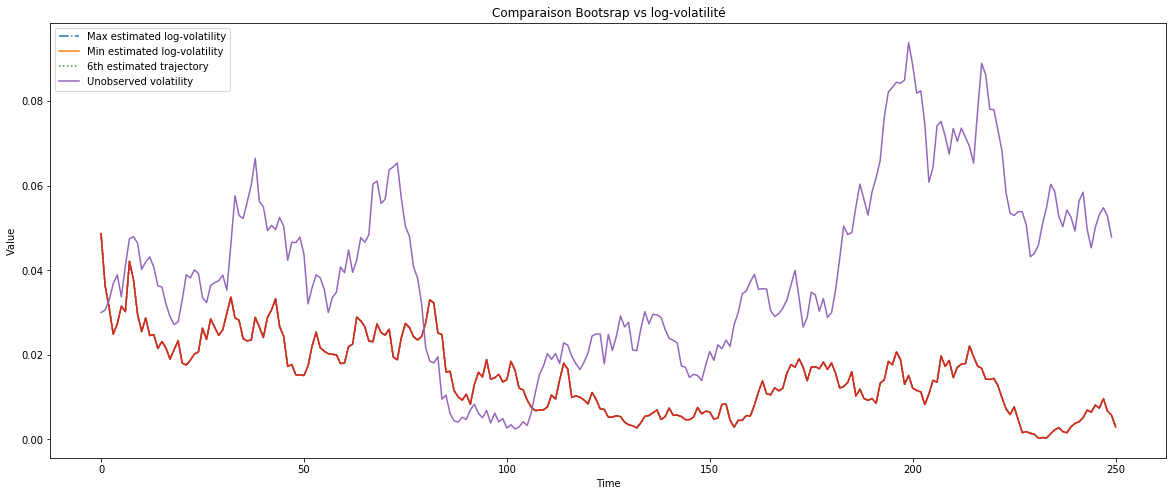

In [74]:
plt.figure(figsize=(20,8))
plt.plot(Vol_hat.max(axis = 1), label = 'Max estimated log-volatility', ls = '-.')
plt.title("Comparaison Bootsrap vs log-volatilité")
plt.ylabel("Value")
plt.xlabel("Time")
plt.plot(Vol_hat.min(axis = 1), label = 'Min estimated log-volatility')
plt.plot(Vol_hat[:,6], label = '6th estimated trajectory', ls = ':')
plt.plot(np.mean(Vol_hat, axis = 1))
plt.plot(Call_Data.True_Volatility.values, label = 'Unobserved volatility')
plt.legend()
plt.show()

Nous pouvons voir ici que comparativement au filtre que nous avions dans le TP2, celui-ci converge très vite vers un échantillon à une seule trajectoire. Le nombre d'observation est pourtant du même ordre de grandeur, cependant, les distributions utilisée diffèrent. En effet, nous avons utilisé ici pour le processus de log-volatilité une loi normale repliée tronquant donc les valeurs négatives.

## Calibration des paramètres du modèle de Heston

Les paramètres utilisés pour modéliser la trajectoire de la volatilité $\sigma_t$ de Heston ont été préalablement fixés. Or, ceci n'est pas réaliste puisqu'ils ne sont en réalité pas connus et que le but de la calibration du modèle est d'estimer ces paramètres à partir du prix observé du Call sur le marché selon le strike $K$ et le ténor $\tau$. 

L'enjeu de pouvoir retrouver le prix du marché d'un Call d'un certain strike $K$ et ténor $\tau$ à partir de la formule de pricing du modèle d'Heston. Cela signifie ainsi qu'il convient de trouver le jeu de paramètre $\theta_0$ optimal permettant à la formule de se rapprocher le plus possible des prix de Calls observés sur le marché.

Ainsi, la méthode la plus naturelle est de considérer un problème d'optimisation, où le vecteur de paramètre doit minimiser l'erreur quadratique entre les prix observés et ceux calculés par la formule, qui n'est autre que la racine de la somme des moindres carrés divisée par le nombre d'observations (root mean squared error).

Plus précisément, en supposant le strike $K$ et le ténor $\tau$ fixé puisque nous ne disposons que de données selon un unique strike 100 et de ténor 1 ans, le problème d'optimisation est le suivant, en posant $y_i$ les prix observés et $C_i$ la fonction de pricing de Heston à chaque instant $i \in [|1,n|]$:

$$
\hat{\theta}_0 = argmin_{\theta_0 \in \Theta} \sqrt{\frac{1}{n}\sum_{i=1}^n [y_i - C_i(\theta_0)]^2}
$$

Ainsi, il convient dans cette partie de résoudre un problème d'optimisation permettant de retrouver les paramètres optimaux sous lesquels le prix des Calls $C_t$ calculés à partir de la formule fermée du modèle de Heston se rapprochent au maximum avec ceux observés sur le marché $y_t$. D'après la littérature, un des algorithmes les plus adaptés à cette situation est celui de Levenberg-Marquardt. Cependant, cette méthode n'est pas robuste notamment lors de la présence de minimum locaux, ainsi, l'optimisation serra plus générale, et sera effectuée via la fonction fmin du package scipy.optimize.

Rappelons que le jeu de paramètre à optimiser est : $\theta_0 = (\kappa, \xi, \theta, \rho, \nu_0)$

### Estimation des paramètres $\theta_0$ du modèle de Heston sur des Calls sur l'indice du S&P500

Il convient dans un premier temps de charger et traiter les données de marché pour les Calls afin de calculer l'ensemble des volatilités implicites.

#### Chargement et traitement des données de marché des options

Les données des options sur l'indice S&P500 ont été une fois de plus téléchargés depuis la plateforme Cboe delayed quotes, et proviennent cette fois ci d'une cotation effectuée le 8 Juin 2020. La date d'expiration pour chaque option est renseignée, ce qui permet d'en déduire chaque maturité.

In [2]:
CallPriceSPX = pd.read_excel("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/SPXCallData.xlsx")
PutPriceSPX = pd.read_excel("C:/Users/Si Dan/Documents/calcul stochastique/Projets_finance_python_Dan/SPXPutData.xlsx")

Dans un premier temps, il convient d'harmoniser le format de la date d'expiration, et ainsi de construire la variable de maturité pour chaque option sachant que la cotation a eu lieu le 12 Juin 2020.

In [3]:
from datetime import timedelta
from datetime import date

n = len(CallPriceSPX['Expiration_Date'])
Expiration_Date = CallPriceSPX['Expiration_Date']

# Déclaration du vecteur Date de composantes égales au 12 Juin 2020
Today=[0 for i in range(n)]
for i in range(n):
    Today[i] = str('2020-06-12')
Today = pd.to_datetime(Today)

# Expression de la différence entre l'expiration et la date du 12 Juin 2020
time_difference = Expiration_Date - Today

# Conversion de la différence en nombre entier de jours, sachant que le type du vecteur est timedelta
m = len(time_difference)
Time_difference = [int(time_difference[i]/np.timedelta64(1, 'D')) for i in range(m)]

# Calcul de la maturité des Options et ajout dans le jeu de données
CallPriceSPX["Maturity"] = [((Time_difference[i] + 1)/365) for i in range(n)]
PutPriceSPX["Maturity"] = [((Time_difference[i] + 1)/365) for i in range(n)]

Il est par ailleurs coutume d'utiliser comme valeur de référence le prix Mid, qui est la moyenne entre les prix Bid et Ask. qui est considéré comme le prix représentant au mieux celui de l'option observé sur le marché. De ce fait, nous implémentons la fonction calculant cette quantité. Si tous les deux prix sont manquantes, on utilise le prix Last qui est le prix fixé lors de la dernière transaction.

In [4]:
def get_fair_price(data):
    Bid = data["Bid"]
    Ask = data["Ask"]
    Last = data["Last_Sale"]
    # On retourne 0 si le bid ou le ask est manquante
    if np.isnan(Bid) or np.isnan(Ask):
        return 0.0
    # On retourne le dernier prix de trade si le bid ou le ask est nul
    elif Bid == 0.0 or Ask == 0.0:
        return Last
    else:
        return (Bid+Ask)/2.0

In [5]:
# Rajout du prix Mid au jeu de données
CallPriceSPX['Mid'] = CallPriceSPX.apply(get_fair_price, axis=1)
PutPriceSPX['Mid'] = PutPriceSPX.apply(get_fair_price, axis=1)

In [6]:
CallPriceSPX.head()

,Expiration_Date,Calls,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid
0,2020-06-12,SPXW200612C00500000,2519.3,0.0,2519.6,2567.6,0,0.02,0.9999,0.0,1,500,0.00274,2543.6
1,2020-06-12,SPXW200612C00600000,0.0,0.0,2419.6,2467.6,0,0.02,0.9999,0.0,0,600,0.00274,2443.6
2,2020-06-12,SPXW200612C00700000,0.0,0.0,2319.6,2367.6,0,0.02,0.9999,0.0,1,700,0.00274,2343.6
3,2020-06-12,SPXW200612C00800000,2187.9,0.0,2219.6,2267.6,0,0.02,0.9998,0.0,1,800,0.00274,2243.6
4,2020-06-12,SPXW200612C00900000,0.0,0.0,2119.6,2167.6,0,0.02,0.9998,0.0,0,900,0.00274,2143.6


In [7]:
PutPriceSPX.head()

,Expiration_Date,Puts,Last_Sale,Net,Bid,Ask,Vol,IV,Delta,Gamma,Open_Int,Strike,Maturity,Mid
0,2020-06-12,SPXW200612P00500000,0.00,0.0,0.0,20.00,0,0.020,-0.0001,0.0,0,500,0.00274,0.00
1,2020-06-12,SPXW200612P00600000,0.00,0.0,0.0,20.00,0,0.020,-0.0001,0.0,0,600,0.00274,0.00
2,2020-06-12,SPXW200612P00700000,0.00,0.0,0.0,20.00,0,0.020,-0.0001,0.0,0,700,0.00274,0.00
3,2020-06-12,SPXW200612P00800000,0.05,0.0,0.0,0.05,0,0.020,-0.0001,0.0,50,800,0.00274,0.05
4,2020-06-12,SPXW200612P00900000,0.00,0.0,0.0,20.00,0,36.733,-0.0001,0.0,0,900,0.00274,0.00


Sachant que la cotation des options sur S&P500 pour les données présentes a été effectuée le 12 Juin 2020, la valeur de l'indice du S&P500 à cet instant précis est égale à 3041.31. Par ailleurs, le taux sans risque actuel, que l'on considère être celui des Bons du Trésor Américain sur 1 ans, est égal à 0,17% selon les données de la CNBC.

#### Calibration des paramètres selon les données

L'objectif de la calibration est la recherche des paramètres du modèle de Heston permettant de calculer les prix des Calls de sorte qu'ils se rapprochent au maximum des prix du marché. Pour cela, il convient d'implémenter la fonction Root Mean Squared Error.

Du fait de la complexité des calculs effectués avec la formule d'Heston et du temps computationnel engendré par l'optimisation numérique, il a été convenu de n'effectuer la calibration que sur les Calls du S&P500 dont la date d'expiration est le 18 Septembre 2020, c'est à dire dont la maturité est d'environ 3 mois. En effet, il a par ailleurs pu être constaté que la calibration effectuée en faisant intervenir des options de différentes maturités donnait des résultats moins satisfaisant, en addition à un temps computationnel plus long. Cela motive ainsi la calibration selon une maturité unique mais avec différents strikes.

Par ailleurs, seuls les Calls dans la monnaie selon le prix Forward du S&P500. Sachant qu'au 18 Septembre 2020, ce prix forward $F$ est égal à 3024.28, qui sera arrondi à 3025, selon un calcul effectué selon la formule de Parité Call Put dans un autre projet portant sur le modèle de Bergomi, il est possible d'implémenter la calibration comme suit :

In [28]:
ATMCallPriceSPX_3M = CallPriceSPX[CallPriceSPX['Expiration_Date'] == '2020-09-18']
ATMCallPriceSPX_3M = ATMCallPriceSPX_3M[ATMCallPriceSPX_3M['Strike'] <= 3025]
n = len(ATMCallPriceSPX_3M)
ATMCallPriceSPX_3M['index'] =[i for i in range (n)]
ATMCallPriceSPX_3M = ATMCallPriceSPX_3M.set_index('index')

def RMSE(*params):
    kappa, theta, xi, rho, v0 = params
    n = len(ATMCallPriceSPX_3M)
    r = 0.14/100
    S0 = 3041.31
    K = ATMCallPriceSPX_3M["Strike"]
    tau = ATMCallPriceSPX_3M["Maturity"]
    Mid = ATMCallPriceSPX_3M["Mid"]
    HestonCall_Price =[0 for i in range(n)]
    for i in range(n):
        HestonCall_Price[i] = HestonCallClosedForm(kappa, theta, xi, rho, v0, r, tau[i], S0, K[i]).real
    residuals = np.power((HestonCall_Price - Mid),2)
    RMSE = np.sqrt(np.sum(residuals)/len(residuals))
    return RMSE

Ainsi, nous définissons l'ensemble de définition de chaque paramètres et nous effectuons une minimisation généralisée.

In [ ]:
# On définit les conditions aux bords pour chaque variable :
bound_kappa = (0.1,8.5)
bound_theta = (0.01, 0.25)
bound_xi = (0.05,2.5)
bound_rho = (-1, -0.1)
bound_v0 = (0.01, 0.09)

general_bounds = (bound_kappa,bound_theta,bound_xi,bound_rho,bound_v0)

optimize_function = lambda params :  RMSE(*params)
param_initiaux = [4, 0.02, 0.4,-0.8, 0.01]
opti_params =spop.minimize(optimize_function,param_initiaux,method='SLSQP',bounds = general_bounds)
#opti_params = spop.fmin(optimize_function, param_initiaux, maxiter=110, maxfun=110)

Malhereusement, le temps computationnel du programme dépasse environ 45 minutes. Il a donc été décidé d'abandonner cette idée et effectuer à la place une minimisation locale avec la fonction fmin, bien que cela ne soit pas le plus optimal.

In [29]:
optimize_function = lambda params :  RMSE(*params)
param_initiaux = [4, 0.03, 0.4,-0.5, 0.01]
opti_params = spop.fmin(optimize_function, param_initiaux, maxiter=100, maxfun=100)

C:\Users\Si Dan\anaconda3\lib\site-packages\ipykernel_launcher.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


In [30]:
(kappa, theta, xi, rho, v0) = opti_params
print("les paramètres calibrés sont : kappa = %f, theta = %f, xi = %f, rho = %f, v0 = %f" % (kappa, theta, xi, rho, v0))

les paramètres calibrés sont : kappa = 13.217108, theta = 0.127902, xi = -0.720755, rho = 0.542605, v0 = 0.032688


La calibration des paramètres semblent pour la plupart cohérent avec les résultats pouvant être trouvés dans la littérature concernant le modèle d'Heston pour les options vanilles sur S&P500, excepté pour le paramètre de corrélaltion $\rho$ qui doit être négatif, et $\xi$ la vol de vol, qui doit être aussi positif. Malheureusement, la calibration prend trop de temps pour être réitéré plusieurs fois. Le temps de calcul est en effet estimé à 15 minutes pour trouver un minimum local, et plus d'une heure pour un minimum global en prenant en compte les bords de définitions.

Ainsi, les paramètres ont pu être calibrés pour l'ensemble des données. Il convient finalement de valoriser l'ensemble des Calls via le modèle de Heston avec les paramètres calibrés précédemment, puis de calculer l'erreur de valorisation qui est le Root Mean Squared Error :

In [31]:
print("L'erreur de valorisation des Calls sur le S&P500 avec les paramètres calibrés est égale à")
print(RMSE(*opti_params))

L'erreur de valorisation des Calls sur le S&P500 avec les paramètres calibrés est égale à
10.791575002250518


Cependant, il est malheureusement courant que la calibration du set de paramètres $\theta$ induit à l'obtention de minimums locaux, signifiant qu'il ne s'agit pas de la solution la plus optimale possible pour obtenir les prix d'options les plus précises. 

Le calcul du Root Mean Squared Error est un indicateur de bonne calibration mais ne permet pas de statuer quant à la qualité de celle ci, étant donné qu'il n'y a aucun moyen de comparaison si le calcul s'effectue seul.

Ainsi, il a été convenu d'établir qu'un set de solution $\hat{\theta}$ était acceptable si la moyenne absolue des erreurs (MAE) entre le prix des Calls du modèle d'Heston et du marché était inférieur ou égal à la moitié du spread bid-ask absolu moyen de l'ensemble des Calls sur le S&P500 :

$$
\frac{1}{n}\sum_{i=0}^n |C^{model}_i(\hat{\theta}) - C^{mkt}_i| \leq \frac{1}{2n}\sum_{i=0}^n |bid_i - ask_i|
$$

In [32]:
def MAE(*params):
    kappa, theta, xi, rho, v0 = params
    n = len(ATMCallPriceSPX_3M)
    r = 0.13/100
    S0 = 3041.31
    K = ATMCallPriceSPX_3M["Strike"]
    tau = ATMCallPriceSPX_3M["Maturity"]
    Mid = ATMCallPriceSPX_3M["Mid"]
    HestonCall_Price =[0 for i in range(n)]
    for i in range(n):
        HestonCall_Price[i] = HestonCallClosedForm(kappa, theta, xi, rho, v0, r, tau[i], S0, K[i]).real
    residuals = np.abs(HestonCall_Price - Mid)
    MAE = np.sum(residuals)/len(residuals)
    return MAE

n = len(ATMCallPriceSPX_3M)
AbsMeanBidAskSpread = (1/(2*n))*np.sum(np.abs(ATMCallPriceSPX_3M['Bid'] - ATMCallPriceSPX_3M['Ask']))

MAE = MAE(*opti_params)

print("Mean Absolute Error = %f" % MAE)
print("Mean Absolute Bid Ask Spread = %f" % AbsMeanBidAskSpread)

if MAE <= AbsMeanBidAskSpread :
    print("Les paramètres issus de la calibration sur le sous ensemble constituent une solution acceptable")
else :
    print("Les paramètres issus de la calibration sur le sous ensemble ne constituent pas une solution acceptable")

Mean Absolute Error = 9.273115
Mean Absolute Bid Ask Spread = 2.671889
Les paramètres issus de la calibration sur le sous ensemble ne constituent pas une solution acceptable


Malheureusement, l'erreur de calibration est plus grande que celle qui peut être tolérée, montrant que nous sommes tombé sur un minimum local. Ainsi, il convient de refaire la calibration. Cependant, sachant que le temps de calcul est chaque fois de 15 minutes, il a été décidé de garder ces paramètres, d'autant plus que la différence d'erreur n'est pas si grande.

Par ailleurs, il est possible de calculer l'ensemble des prix des Calls de maturité de 3 mois, et pour l'ensemble des Strikes, selon le modèle d'Heston et les paramètres calibrés, afin de les comparer visuellement avec les prix du marché des Calls correspondants :

In [33]:
ATMCallPriceSPX_3M = CallPriceSPX[CallPriceSPX['Expiration_Date'] == '2020-09-18']
n = len(ATMCallPriceSPX_3M)
ATMCallPriceSPX_3M['index'] =[i for i in range (n)]
ATMCallPriceSPX_3M = ATMCallPriceSPX_3M.set_index('index')

def AllHestonPrice(*params):
    kappa, theta, xi, rho, v0 = params
    n = len(ATMCallPriceSPX_3M)
    r = 0.13/100
    S0 = 3041.31
    K = ATMCallPriceSPX_3M["Strike"]
    tau = ATMCallPriceSPX_3M["Maturity"]
    Mid = ATMCallPriceSPX_3M["Mid"]
    HestonCall_Price =[0 for i in range(n)]
    for i in range(n):
        HestonCall_Price[i] = HestonCallClosedForm(kappa, theta, xi, rho, v0, r, tau[i], S0, K[i]).real
    return HestonCall_Price

ATMCallPriceSPX_3M['Heston_Price'] = AllHestonPrice(*opti_params)

C:\Users\Si Dan\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


les prix calculés selon le modèle de Heston peuvent ainsi être comparés à l'occasion avec les prix Mid observés sur le marché :

Text(0.5, 1.0, 'Comparison Price of Calls, Maturity 3 months')

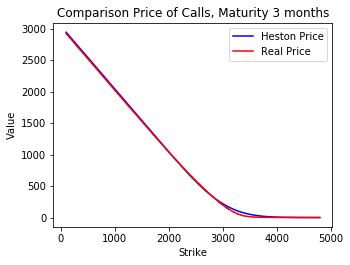

In [34]:
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
iv_strike_calculated = ATMCallPriceSPX_3M[['Strike','Heston_Price']].sort_values('Strike')

# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
iv_strike_observed = ATMCallPriceSPX_3M[['Strike','Mid']].sort_values('Strike')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(iv_strike_calculated['Strike'],iv_strike_calculated['Heston_Price'], color = 'b', label = 'Heston Price')
plt.plot(iv_strike_calculated['Strike'],iv_strike_observed['Mid'], color = 'r', label = 'Real Price')
plt.xlabel('Strike')
plt.ylabel('Value')
leg = ax.legend()
plt.title('Comparison Price of Calls, Maturity 3 months')

Nous pouvons ainsi constater que la calibration a assez bien fonctionné étant donné que pour l'ensemble des Strike, les prix selon le modèle d'Heston et ceux du marchés sont fortement similaires, dont la différence est quasi-inobservable graphiquement. Les erreurs semblent être concentrés autour "de la monnaie" c'est à dire autour du Strike 3200, où l'inflexion des deux courbes est différente.

### Calcul de la volatilité implicite des Calls sous le modèle d'Heston

La volatilité implicite du modèle de Heston est la volatilité $\sigma_{imp}$ tel que le prix actuel des options sur S&P500 calculé par la formule de Black Scholes, est égal à celui calculé par le modèle d'Heston. Plus particulièrement, $\sigma_{imp}$ est défini tel que :

$$
C_{BS}(\sigma_{imp}^2,T,K) = C_{Heston}(T,K)
$$

Ce qui équivaut à établir que $\sigma_{imp}$ est racine de la fonction $C_{BS}(\sigma_{imp}^2,T,K) = C_{Heston}(T,K)$ :

$$
\sigma_{imp} = root_\sigma (C_{BS}(\sigma^2,T,K) - C_{Heston}(T,K))
$$

Ici, la volatilité implicite sera calculée pour l'ensemble des Calls dont la date d'expiration est le 18 Septembre 2020, quelque soit les Strikes.

Sachant que le prix d'Heston a déjà été calculé pour l'ensemble des Calls, la formule de Black Scholes est aussi implémentée :

In [35]:
def CallFormulaBS(S0,r,K,T,sigma):
    d1 = (math.log(S0/K)+(r+(sigma**2/2))*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    C = S0*st.norm.cdf(d1) - K*math.exp(-r*T)*st.norm.cdf(d2)
    return C

De ce fait, le calcul de la volatilité implicite pour l'ensemble des Calls s'effectue grâce à la fonction fsolve de scipy.optimize pour trouver la racine de la fonction de variable $\sigma$ mesurant la différence entre le prix Black Scholes de l'option et celui du modèle d'Heston :

In [64]:
def ImpliedVolCall(S0,r,K,T,Call):
    _S0, _r, _K, _T, _Call = S0,r,K,T,Call
    m = _S0/_K
    sigma_0 = math.sqrt(2*abs(math.log(m))/_T)
    difference_call = lambda sigma : _Call - CallFormulaBS(_S0, _r, _K, _T,sigma)
    iv = spop.brentq(difference_call, -100,100)
    return iv

Le calcul de la volatilité implicite peut donc être effectué sur l'ensemble des prix Mid des options exprimés en fonction du strike $K$, sachant que tous les paramètres requis en entrée sont à notre disposition :

In [65]:
def all_implied_Vol_Call(data):
    S0 = 3041.31
    r = 0.14/100
    K = data["Strike"]
    T = data["Maturity"]
    HestonPrice = data["Heston_Price"]
    return float(ImpliedVolCall(S0,r,K,T,HestonPrice))

In [66]:
ATMCallPriceSPX_3M["Heston_iv"] = ATMCallPriceSPX_3M.apply(all_implied_Vol_Call, axis = 1)

Ainsi, la volatilité implicite selon le modèle d'Heston et celui observé sur le marché peuvent être tracées afin d'en établir une comparaison :

Text(0.5, 1.0, 'Comparison IV of Calls, Maturity 3 months')

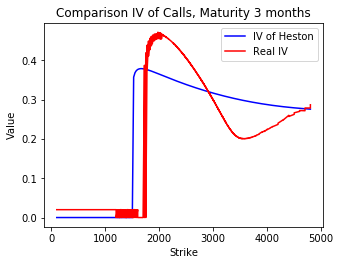

In [67]:
# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
iv_strike_calculated = ATMCallPriceSPX_3M[['Strike','Heston_iv']].sort_values('Strike')

# On définit un dataframe contenant la volatilité implicite des Calls en fonction du Strike en indice
iv_strike_observed = ATMCallPriceSPX_3M[['Strike','IV']].sort_values('Strike')

fig, ax = plt.subplots(figsize=(5, 3.75))

plt.plot(iv_strike_calculated['Strike'],iv_strike_calculated['Heston_iv'], color = 'b', label = 'IV of Heston')
plt.plot(iv_strike_calculated['Strike'],iv_strike_observed['IV'], color = 'r', label = 'Real IV')
plt.xlabel('Strike')
plt.ylabel('Value')
leg = ax.legend()
plt.title('Comparison IV of Calls, Maturity 3 months')

Malheureusement, la volatilité implicite de Heston ne peut s'ajuster correctement à celle  du marché. Il convient de remarquer que la volatilité implicite est quasi nulle pour les Calls dont le Strike est inférieur à 1800, faisant ainsi apparaître des erreurs de calculs pour les données de marchés du CBOE dans la valorisation de leur options. 

## pricing des Variance Swap sur S&P500 sous le modèle d'Heston

Le modèle de Heston est un modèle de volatilité stochastique, stipulant que la dynamique du prix du sous-jacent $S$ et de sa variance instantanée $v$ s'exprime de la manière suivante, sous la probabilité risque neutre $\mathbb{Q}$ :

$$
\left\{
    \begin{array}{lll}
    dS_t = S_t(r dt + \sqrt{v_t} dW_t^1) \\
    dv_t = \kappa(\theta - v_t) dt + \xi \sqrt{v_t} dW_t^2 \\
    d<W_t^1, W_t^2> = \rho dt
    \end{array}
\right.
$$

avec $W_t^1$ et $W_t^1$ des $\mathbb{Q}$ mouvements browniens.

Il est ainsi aisé de constater que la volatilité $\sigma$ suit un modèle de taux d'intéret à court terme nommé Cox-Ingersoll-Ross (CIR) permettant ainsi à cette volatilité stochastique un retour à la moyenne positive et à long terme $\theta$ selon le paramètre $\kappa$. Le terme $\sqrt{\sigma_t}$ permet de s'assurer que la volatilité reste positive à tout instant. Il faut enfin noter que le terme $\xi$ est la volatilité de la volatilité.

En parallèle, il est connu que le prix actuel d'un variance swap, ou sa 'fair variance', est telle que :

$$
(\sigma_0^T)^2 = \mathbb{E}^{Q}[\frac{1}{T}\int_{0}^{T}\sigma_s^2ds] = \mathbb{E}^{Q}[\frac{1}{T}\int_{0}^{T}v_sds]
$$

Ainsi, sachant que la dynamique de $\sigma_t$ a été définie, il est possible d'intégrer entre 0 et $t$ pour obtenir :

$$
v_t - v_0 = \kappa\theta t- \kappa\int_0^t v_s ds + \int_0^t \sqrt{v_s} dW_s^2
$$

En calculant l'espérance des deux membres :

$$
\mathbb{E}^{Q}[v_t] - v_0 = \kappa\theta t- \kappa \mathbb{E}^{Q}[\int_0^t v_s ds] + \mathbb{E}^{Q}[\int_0^t \sqrt{v_s} dW_s^2]
$$

Sachant qu'une intégrale de Wiener est d'espérance nulle, en posant $m(t) = \mathbb{E}^{Q}[v_t]$ et d'après le théorème de Fubini, on a

$$
m(t) - v_0 = \kappa\theta t - \kappa \int_0^t \mathbb{E}^{Q}[v_s] ds = \kappa\theta t - \kappa \int_0^t m(s) ds
$$

En dérivant les deux membres, on obtient l'équation différentielle ordinaire :

$$
m'(t) = \kappa(\theta  - \kappa m(t))
$$

dont la solution est donnée par : $m(t) = \theta + ce^{-\kappa t}$. Sachant que $m(0) = v_0$ , $c = v_0 - \theta$ et la solution devient :

$$
\mathbb{E}^{Q}[v_t] = \theta + e^{-\kappa t}(v_0 - \theta)
$$

De ce fait, et par le lemme de Fubini, le prix actuel d'un Variance Swap sous le modèle d'Heston est égal à :

$$
(\sigma_0^T)^2  = \mathbb{E}^{Q}[\frac{1}{T}\int_{0}^{T}v_sds] = \frac{1}{T}\int_{0}^{T}\mathbb{E}^{Q}[v_s] ds
$$

D'où :

$$
(\sigma_0^T)^2  = \theta + (v_0 - \theta)\frac{1-e^{-\kappa T}}{\kappa T}
$$

### Application numérique pour différentes maturités

Les paramètres du modèle d'Heston ont été calibrés sur un autre projet spécifiquement dédié à celui ci pour des données provenant d'une cotation du 8 Juin 2020. Plus précisément, les paramètres calibrés sont telles que :

$$
\kappa = 13.217108, \theta = 0.127902, \xi = -0.720755, \rho = 0.542605, v_0 = 0.032688
$$

De ce fait, en utilisant les maturités des options sur S&P500, les nouvelles données sont créées :

In [71]:
theta = 0.128
kappa = 13.21
v0 = 0.032

Maturity = CallPriceSPX["Maturity"].unique()
n = len(Maturity)

Index = [i for i in range(n)]
HestonVSPrice = pd.DataFrame(index = Index)

HestonVSPrice['Maturity'] = Maturity

HestonVS_Price = []
for T in Maturity :
    HestonVS_Price.append(theta + (v0 - theta)*((1-math.exp(-kappa*T))/(kappa*T)))

HestonVSPrice['HestonFairVariance'] = HestonVS_Price

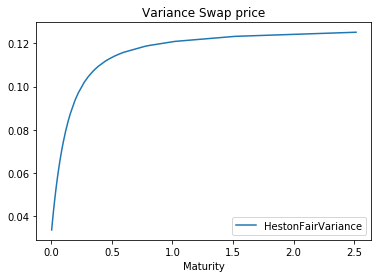

In [72]:
# On définit un dataframe contenant le prix des Variance Swap selon la maturité
Heston_VSPrice = HestonVSPrice[['Maturity', 'HestonFairVariance']].set_index('Maturity').sort_index()

# On trace le Smile de Volatilité
Heston_VSPrice.plot(title = 'Variance Swap price')

La structure à terme de la variance Swap est caractéristique de ce qui peut être observé sur le marché.

# Annexes

## Valorisation d'actifs contingents sous volatilité stochastique

### Equation aux dérivées partielles de pricing

Dans sa forme la plus générale, le sous jacent et sa volatilité possède la dynamique suivante sous un modèle à volatilité stochastique :

$$
\left\{
    \begin{array}{lll}
    dS_t = S_t(\mu_t dt + \sigma_t dB_t^1) \\
    d\sigma_t = a_t dt + b_t dB_t^2 \\
    d<B_t^1, B_t^2> = \rho dt
    \end{array}
\right.
$$

On considère un marché composé de l'actif risqué $S$ de prix $(S_t)_{t \geq 0}$ et de l'actif sans risque $S_t^0$ dont le prix a pour dynamique : $dS_t^0 = rS_t^0 dt$, avec r le taux sans risque. En prenant en compte la remarque concernant la converture en vega, est ajouté un actif liquide supplémentaire $C^0$ côté au prix $C_t^0 = C^0(t,S, \sigma)$ avec $\frac{\partial C^0}{\partial \sigma} > 0$ permettant cette opération, et donc assurant la complétude des marchés.

Ce faisant, en constituant un portefeuille autofinançant de couverture de l'actif contingent (qui sera dans le cadre de ce projet une option dont le sous-jacent est $S$) composé d'actifs sans risque $S_t^0$, d'une quantité $\delta_t$ d'actifs risqués $S$, sous jacent de l'actif contingent, ainsi que de $\omega_t$ actifs liquides $C^0$, il est possible de déduire le prix de cet actif contingent sous le modèle de volatilité stochastique :

Par définition d'un portefeuille autofinançant, la dynamique de son prix est donc : 

$$
dV_t = (V_t- \delta_t S_t - \omega_t C_t^0)rdt + \delta_t dS_t + \omega_t dC_t^0
$$

Sachant que : $C_t^0 = C^0(t,S, \sigma)$, alors sa différentielle s'exprime comme suit :

$$
dC_t^0 = dC^0(t,S, \sigma) = \frac{\partial C^0}{\partial t}dt + \frac{\partial C^0}{\partial S}dS_t + \frac{\partial C^0}{\partial \sigma}d\sigma_t + \frac{1}{2} (\frac{\partial^2 C^0}{\partial S^2}d<S>_t + \frac{\partial^2 C^0}{\partial \sigma^2}d<\sigma>_t) + \frac{\partial^2 C^0}{\partial S \partial \sigma} d<S,\sigma>_t
$$

d'où :

$$
dC_t^0 =  \frac{\partial C^0}{\partial S}dS_t + \frac{\partial C^0}{\partial \sigma}d\sigma_t + (\frac{\partial C^0}{\partial t} + \frac{1}{2}\sigma_t^2 S_t^2 \frac{\partial^2 C^0}{\partial S^2} + \frac{1}{2}b_t^2\frac{\partial^2 C^0}{\partial \sigma^2} + S_t \sigma_t b_t \rho \frac{\partial^2 C^0}{\partial S \partial \sigma})dt
$$

En posant le générateur infinitésimal $\mathscr{L}_t = \frac{\partial}{\partial t} + \frac{1}{2}\sigma_t^2 S_t^2 \frac{\partial^2}{\partial S^2} + \frac{1}{2}b_t^2\frac{\partial^2}{\partial \sigma^2} + S_t \sigma_t b_t \rho \frac{\partial^2}{\partial S \partial \sigma}$, nous avons :

$$
dC_t^0 =  \frac{\partial C^0}{\partial S}dS_t + \frac{\partial C^0}{\partial \sigma}d\sigma_t + \mathscr{L}_tC^0 dt.
$$

Ainsi, la dynamique $V_t$ du portefeuille satisfait :

$$
dV_t = (V_t- \delta_t S - \omega_t C^0)rdt + \delta_t dS_t + \omega_t \frac{\partial C^0}{\partial S}dS_t + \omega_t\frac{\partial C^0}{\partial \sigma}d\sigma_t + \omega_t \mathscr{L}_tC^0 dt
$$

C'est à dire :

$$
dV_t = (V_t- \delta_t S - \omega_t C^0)rdt + (\delta_t + \omega_t \frac{\partial C^0}{\partial S})dS_t + \omega_t\frac{\partial C^0}{\partial \sigma}d\sigma_t + \omega_t \mathscr{L}_tC^0 dt. \ \ (1)
$$

Parallèlement, en considérant la fonction régulière $v$ telle que le prix du portefeuille soit tel que $V_t = v(t, S_t, \sigma_t)$, alors par la formule d'Ito :

$$
dV_t = \frac{\partial v}{\partial t}dt + \frac{\partial v}{\partial S}dS_t + \frac{\partial v}{\partial \sigma}d\sigma_t + \frac{1}{2} (\frac{\partial^2 v}{\partial S^2}d<S>_t + \frac{\partial^2 v}{\partial \sigma^2}d<\sigma>_t) + \frac{\partial^2 v}{\partial S \partial \sigma} d<S,\sigma>_t
$$

Par le même raisonnement effectué que pour $C^0$, nous avons :

$$
dV_t = dv(t, S, \sigma) =  \frac{\partial v}{\partial S}dS_t + \frac{\partial v}{\partial \sigma}d\sigma_t + \mathscr{L}_tv dt \ \ (2)
$$

Par identification des termes devant les différentielles qui est nécessaire afin d'obtenir l'égalité entre les équations $(1)$ et $(2)$, les ratios de couvertures ainsi que la fonction $v$ doivent satisfaire :

$$
\left\{
    \begin{array}{lll}
    \delta_t =  \frac{\partial v}{\partial S} - \omega_t \frac{\partial C^0}{\partial S}\\
    \omega_t = \frac{\partial v}{ \partial \sigma}/\frac{\partial C^0}{\partial \sigma} \\
    (V_t- \delta_t S_t - \omega_t C_t^0)r + \omega_t \mathscr{L}_tC^0  = \mathscr{L}_tv
    \end{array}
\right.
$$

Ce qui permet ainsi la couverture en delta-vega.

Par substitution des termes $\delta_t$ et $\omega_t$ dans la dernière égalité, celle ci devient :

$$
rV_t- rS_t\frac{\partial v}{\partial S}   + rS_t\frac{\partial C^0}{\partial S}\frac{\frac{\partial v}{ \partial \sigma}}{\frac{\partial C^0}{\partial \sigma}}  - rC_t^0 \frac{\frac{\partial v}{ \partial \sigma}}{\frac{\partial C^0}{\partial \sigma}} + \frac{\frac{\partial v}{ \partial \sigma}}{\frac{\partial C^0}{\partial \sigma}} \mathscr{L}_tC^0  = \mathscr{L}_tv
$$

D'où :

$$
\mathscr{L}_tv - rv + rS_t\frac{\partial v}{\partial S} = \frac{\partial v}{\partial \sigma} \frac{\mathscr{L}_tC^0 - rC^0 + rS_t \frac{\partial C^0}{\partial S}}{\partial C^0 / \partial \sigma}
$$

Ainsi, en posant $\lambda_t = \lambda(t,S, \sigma) = - \frac{\mathscr{L}_tC^0 - rC^0 + rS_t \frac{\partial C^0}{\partial S}}{\partial C^0 / \partial \sigma}$ qui ne dépend aucunement du prix de l'actif contingent $v$ mais seulement de celui de l'actif liquide ajouté $C^0$, il est possible d'établir que  le prix $V$ de l'actif contingent (dans le cadre du projet il s'agira d'une option de sous-jacent $S$) de payoff $h(S_T)$ au temps $T$, par analogie au raisonnement de Black Scholes, satisfait l'équation aux dérivées partielles:

$$
\mathscr{L}_tv - rv + rS_t\frac{\partial v}{\partial S} + \frac{\partial v}{\partial \sigma}\lambda_t =0
$$

avec : $v(T, S, \sigma) = h(S_T)$, et $\mathscr{L}_t = \frac{\partial}{\partial t} + \frac{1}{2}\sigma_t^2 S_t^2\frac{\partial^2}{\partial S^2} + \frac{1}{2}b_t^2\frac{\partial^2}{\partial \sigma^2} + S_t \sigma_t b_t \rho \frac{\partial^2}{\partial S \partial \sigma}$.

### Pricing sous probabilité risque neutre

En reprenant la dynamique du portefeuille qui est telle que :

$$
dV_t =  dv(t, S, \sigma) = \mathscr{L}_tV dt+  \frac{\partial V}{\partial S}dS_t + \frac{\partial V}{\partial \sigma}d\sigma_t
$$

D'après ce qui précède, la fonction régulière $v$ satisfait l'équation aux dérivées partielles :

$$
\mathscr{L}_tv - rv + rS_t\frac{\partial v}{\partial S} + \frac{\partial v}{\partial \sigma}\lambda_t =0
$$

avec : $v(T, S, \sigma) = h(S_T)$, et $\mathscr{L}_t = \frac{\partial}{\partial t} + \frac{1}{2}\sigma_t^2 \frac{\partial^2}{\partial S^2} + \frac{1}{2}b_t^2\frac{\partial^2}{\partial \sigma^2} + S_t \sigma_t b_t \rho \frac{\partial^2}{\partial S \partial \sigma}$.

C'est à dire que :

$$
\mathscr{L}_tv = rv - rS_t\frac{\partial v}{\partial S} - \frac{\partial v}{\partial \sigma}\lambda_t
$$

En réinjectant cette quantité dans la dynamique du prix $V_t$ du portefeuille et donc de l'actif contingent, celle-ci devient:

$$
dV_t = rV_tdt + \frac{\partial V}{\partial S}(dS_t - rS_tdt) + \frac{\partial V}{\partial \sigma} (d\sigma_t - \lambda_tdt).
$$

Par la suite, la probabilité risque-neutre $Q$, sous laquelle le prix actualisé des actifs est une martingale et qui existe sous l'hypothèse d'absence d'opportunité d'arbitrage, est construite dans ce contexte de volatilité stochastique :

Rappelons que la dynamique du sous-jacent et de sa volatilité sous la probabilité historique $P$ :

$$
\left\{
    \begin{array}{lll}
    dS_t = S_t(\mu_t dt + \sigma_t dB_t^1) \\
    d\sigma_t = a_t dt + b_t dB_t^2 \\
    d<B_t^1, B_t^2> = \rho dt
    \end{array}
\right.
$$

De ce fait, ce système devient :

$$
\left\{
    \begin{array}{lll}
    dS_t = r S_t dt + \sigma_t S_t(\frac{\mu_t - r}{\sigma_t}dt + dB_t^1) \\
    d\sigma_t = a_t dt + b_t dB_t^2 \\
    d<B_t^1, B_t^2> = \rho dt
    \end{array}
\right.
$$

En posant $\theta_t = \frac{\mu_t - r}{\sigma_t}$, puis la probabilité $\mathbb{Q}$ équivalente à $\mathbb{P}$ et dont la densité par rapport à $P$ est donnée par : $L_T = exp(-\int_{0}^{T}\theta_s dB_s^1 - \int_{0}^{T}\theta_s^2 ds)$ qui est une martingale locale puis une martingale si celle ci respecte la condition de Novikov (on la supposera respectée ici), alors d'après le théorème de Girsanov, $W_t^1 = B_t^1 + \int_0^t \theta_sds = B_t^1 + \int_0^t \frac{\mu_s - r}{\sigma_s}ds$ est un mouvement brownien sous $\mathbb{Q}$.

Cela permet ainsi d'établir que : $dS_t = rS_t dt + \sigma_t dW_t^1$ et donc que sous $\mathbb{Q}$, le prix actualisé du sous-jacent $S$ est une martingale. Ainsi, la probabilité $\mathbb{Q}$ est donc la probabilité risque-neutre. Il est à noter que la dynamique du prix actualisé du sous-jacent $S$ est égale à : $dS_t - rS_tdt$. Notons que la volatilité est stochastique, et donc possède une prime de risque qu'il convient de définir.

Plus généralement, l'ensemble des prix actualisés des actifs doivent être des martingales sous la probabilité risque-neutre $\mathbb{Q}$, ce qui inclut le prix actualisé du portefeuille de couverture et donc de l'actif contingent. Or, il a été stipulé précédemment que la dynamique du portefeuille était, en posant $\tilde{V}_t$ son prix actualisé:

$$
dV_t - rV_tdt = d\tilde{V}_t = \frac{\partial V}{\partial S}(dS_t - rS_tdt) + \frac{\partial V}{\partial \sigma} (d\sigma_t - \lambda_tdt) = \frac{\partial V}{\partial S}\sigma_tdW_t^1 + \frac{\partial V}{\partial \sigma} (d\sigma_t - \lambda_tdt).
$$

Sachant que $W_t^1$ est déjà un mouvement brownien sous $\mathbb{Q}$, il est nécessaire que la quantité définie par la dynamique $d\sigma_t + \lambda_tdt$ soit une martingale sous $\mathbb{Q}$ afin que le prix actualisé du portefeuille soit une martingale sous cette même probabilité.

Pourtant, la volatilité stochastique a pour dynamique : $d\sigma_t = a_t dt + b_t dB_t^2$.

Ainsi, $d\sigma_t - \lambda_tdt  = b_t(\frac{a_t - \lambda_t}{b_t} + dB_t^2)$. 

En posant $\theta^{'}_t = \frac{a_t - \lambda_t}{b_t}$ et $W_t^2 = B_t^2 + \int_0^t \theta^{'}_s ds$, alors cette dernière quantité doit être un mouvement brownien sous $\mathbb{Q}$ puisque le prix actualisé du portefeuille doit être une martingale sous cette probabilité. La réciproque du théorème de Girsanov permet ainsi de définir $L^{'}_T = exp(-\int_{0}^{T}\theta^{'}_s dB_s^2 - \int_{0}^{T}\theta_s^{'2} ds)$ qui est donc la densité de $\mathbb{Q}$ par rapport à la probabilité historique $\mathbb{P}$. Nous pouvons ainsi aisément comprendre la non-unicité de la probabilité risque-neutre qui contredit ainsi l'hypothèse de complétude des marchés, qui ne peut être présent dans les modèles à volatilité stochastique si le portefeuille de couverture ne contient que des actions.

Il faut noter que $\theta^{'}_t = \frac{a_t - \lambda_t}{b_t}$ est la prime de risque liée au risque de volatilité. Pour conclure, la dynamique du modèle général de volatilité stochastique sous la probabilité risque-neutre $\mathbb{Q}$ est donnée par :

$$
\left\{
    \begin{array}{lll}
    dS_t = r S_t dt + \sigma_t S_tdW_t^1 \\
    d\sigma_t = \lambda_t dt + b_t dW_t^2 \\
    d<W_t^1, W_t^2> = \rho dt
    \end{array}
\right.
$$

avec $W_t^1$ et $W_t^2$ qui sont des $\mathbb{Q}$ mouvements browniens.

De ce fait, le prix $V_t$ du portefeuille autofinançant de converture a pour dynamique :

$$
dV_t - rV_tdt = \sigma_t S_tdW_t^1 + b_t dW_t^2
$$

permettant ainsi de confirmer que son prix actualisé est bel et bien une $\mathbb{Q}$ martingale.

Ainsi, sachant que le portefeuille autofinançant réplique un actif contingent, que l'on suppose ici être un call de sous-jacent $S$ de payoff $h(S_T)$, dont le prix est supposé égal à $C_t = c(t, S_t, \sigma_t)$, alors il est clair que pour tout $t$, $V_t = C_t$, alors il est possible, en posant $\tilde{C}_t$ le prix actualisé du call, d'établir que :

$$
\tilde{C}_t = \mathbb{E}^{\mathbb{Q}}[\tilde{C}_T|\mathscr{F}_t] = \mathbb{E}^{\mathbb{Q}}[\tilde{C}_T| S_t = S, \sigma_t = \sigma]
$$

d'où : 

$$
C_t = c(t, S, \sigma) = e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}[h(S_T)|S_t = S, \sigma_t = \sigma]
$$

Ce résultat est classique puisqu'il provient du théorème fondamentale de la valorisation des actifs, stipulant que le prix d'un actif est l'espérance de l'ensemble de ses flux futures actualisés. Il est ainsi possible d'établir le prix d'une option et de n'importe quel actif contingent grâce à cette formule en appliquant la méthode de Monte Carlo.

## Modèle de Heston

### Equation aux dérivées partielles de Heston

Le modèle de Heston est un modèle de volatilité stochastique, stipulant que la dynamique du prix du sous-jacent $S$ et de sa volatilité $\sigma$ s'exprime de la manière suivante, sous la probabilité risque neutre $\mathbb{Q}$ :

$$
\left\{
    \begin{array}{lll}
    dS_t = S_t(r dt + \sqrt{\sigma_t} dW_t^1) \\
    d\sigma_t = \kappa(\theta - \sigma_t) dt + \xi \sqrt{\sigma_t} dW_t^2 \\
    d<W_t^1, W_t^2> = \rho dt
    \end{array}
\right.
$$

avec $W_t^1$ et $W_t^1$ des $\mathbb{Q}$ mouvements browniens.

Il est ainsi aisé de constater que la volatilité $\sigma$ suit un modèle de taux d'intéret à court terme nommé Cox-Ingersoll-Ross (CIR) permettant ainsi à cette volatilité stochastique un retour à la moyenne positive et à long terme $\theta$ selon le paramètre $\kappa$. Le terme $\sqrt{\sigma_t}$ permet de s'assurer que la volatilité reste positive à tout instant. Il faut enfin noter que le terme $\xi$ est la volatilité de la volatilité.

Il a été démontré précédemment que le prix $V_t = v(t,S, \sigma)$ du portefeuille autofinançant répliquant celui d'un actif contingent de sous-jacent $S$, et donc de cet actif contingent lui même, satisfait dans le cadre général l'équation aux dérivées partielles suivante :

$$
\mathscr{L}_tv - rv + rS_t\frac{\partial v}{\partial S} + \frac{\partial v}{\partial \sigma}\lambda_t =0
$$

avec : $c(T, S, \sigma) = h(S_T)$, $\mathscr{L}_t = \frac{\partial}{\partial t} + \frac{1}{2}\sigma_t^2 S_t^2\frac{\partial^2}{\partial S^2} + \frac{1}{2}b_t^2\frac{\partial^2}{\partial \sigma^2} + S_t \sigma_t b_t \rho \frac{\partial^2}{\partial S \partial \sigma}$ et $\lambda_t = \lambda(t,S, \sigma) = - \frac{\mathscr{L}_tC^0 - rC^0 + rS_t \frac{\partial C^0}{\partial S}}{\partial C^0 / \partial \sigma}$.

Sachant que le modèle général de la volatilité stochastique est défini par :

$$
\left\{
    \begin{array}{lll}
    dS_t = S_t(\mu_t dt + \sigma_t dB_t^1) \\
    d\sigma_t = a_t dt + b_t dB_t^2 \\
    d<B_t^1, B_t^2> = \rho dt
    \end{array}
\right.
$$

Alors il convient par identification au modèle de Heston de substituer dans l'équation aux dérivées partielles précédente le terme $b_t$ par $\xi \sqrt{\sigma_t}$ et le terme $\sigma_t$ de la dynamique de $S_t$ par $\sqrt{\sigma_t}$.

L'actif contingent étant ici supposé être un Call de sous-jacent $S$ et de payoff $h(S_T)$, dont le prix est défini par $C_t = c(t,S_t, \sigma_t)$ , alors son prix est égal à celui de son portefeuille autofinançant de couverture. Ainsi, $C_t = V_t$, et par substitution ce prix satisfait finalement sous le modèle de Heston l'équation aux dérivées partielle suivante :

$$
\mathscr{L}_tc - rc + rS_t\frac{\partial c}{\partial S} + \frac{\partial c}{\partial \sigma}\lambda_t =0
$$

avec : $c(T, S, \sigma) = h(S_T)$, $\mathscr{L}_t = \frac{\partial}{\partial t} + \frac{1}{2}\sigma_t S_t^2\frac{\partial^2}{\partial S^2} + \frac{1}{2}\xi^2 \sigma_t \frac{\partial^2}{\partial \sigma^2} + S_t \xi \sigma_t \rho \frac{\partial^2}{\partial S \partial \sigma}$ et $\lambda_t = \lambda(t,S, \sigma) = - \frac{\mathscr{L}_tC^0 - rC^0 + rS_t \frac{\partial C^0}{\partial S}}{\partial C^0 / \partial \sigma}$.

$\lambda_t$ est cependant une fonction dépendant de l'actif $C^0$ utilisé pour couvrir le risque de volatilité. S'il est réinjecté dans l'équation aux dérivées partielles précédente, celle ci devient : 

$$
\frac{1}{\frac{\partial c}{\partial \sigma}}(\mathscr{L}_tc - rc + rS_t\frac{\partial c}{\partial S}) = \frac{1}{\frac{\partial C^0}{\partial \sigma}}(\mathscr{L}_tC^0 - rC^0 + rS_t\frac{\partial C^0}{\partial S})
$$

IL est donc possible de se rendre compte que le membre à gauche de l'égalité ne dépend que de la fonction $c$ tandis que celui à droite ne dépend que de la fonction $C^0$. Ainsi, tous deux doivent être égaux à une fonction $f$ dépendant des trois variables : $t$, $\sigma$, et $S$, et donc égal à $-\lambda_t$ par identification.

Concernant le membre à gauche, puisqu'il dépend de la fonction $c$ du prix du Call que l'on souhaite calculer, il satisfait donc : 

$$
\mathscr{L}_tc - rc + rS_t\frac{\partial c}{\partial S} = \frac{\partial c}{\partial \sigma}f
$$

Les travaux de Heston lui ont permis de déterminer la fonction $f$ qui est égale à $ \kappa(\theta - \sigma_t) - \Lambda(t,\sigma,S)$ où $\Lambda(t,\sigma,S)$ est le prix de marché du risque de volatilité. Ce prix a été arbitrairement choisi comme étant fonction linéaire de la volatilité. Plus précisément, $\Lambda(t,\sigma,S) = \lambda \sigma_t$.

De ce fait, l'équation aux dérivées partielle de Heston est finalement :

$$
\frac{\partial c}{\partial t} + \frac{1}{2}\sigma_t S_t^2\frac{\partial^2 c}{\partial S^2} + \frac{1}{2}\xi^2 \sigma_t \frac{\partial^2 c}{\partial \sigma^2} + S_t \xi \sigma_t \rho \frac{\partial^2 c}{\partial S \partial \sigma} - rc + rS_t\frac{\partial c}{\partial S} - (\kappa(\theta - \sigma_t) - \lambda \sigma_t) \frac{\partial c}{\partial \sigma} = 0
$$

avec : $c(T, S, \sigma) = h(S_T)$.

### Formule fermée du prix d'un Call sous le modèle de Heston

Le même raisonnement que celui effectué dans le cas général permet d'établir que sous le modèle de Heston, le prix $C_t$ d'un Call de payoff $h(S_T)$, considéré comme égal à $(S_T-K)_{+}$, satisfait :

$$
C_t = c(t, S, \sigma) = e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}[h(S_T)|S_t = S, \sigma_t = \sigma]
$$

Il est donc judicieux de considérer que le prix du Call peut être exprimé sous la forme suivante, à l'instar du prix sous le modèle de Black Scholes:

$$
C_t = c(t, S, \sigma) = S_tP_1 + Ke^{-r(T-t)}P_2
$$

$où$ $P_1$ et $P_2$, fonctions de $t$, $S$, $\sigma$ peuvent être interprétés comme les probabilités risque-neutres que le Call expire dans la monnaie. Déterminer la formule du prix du Call sous Heston revient à chercher la solution de l'équation aux dérivées partielles de Heston sous la forme définie ci dessus.

Il est néessaire d'effectuer deux changements de variables:

- $x = ln(S)$, le logarithme du prix du sous-jacent
- $\tau = T-t$, le ténor du Call

Le prix du Call devient donc :

$$
C_t = c(t, S, \sigma) = e^{x_t}P_1(\tau, x, \sigma) + Ke^{-r\tau}P_2(\tau, x, \sigma)
$$.

Les dérivées partielles de la fonction $c$ du prix du Call par rapport à celui du sous jacent $S$ peuvent être reformulés comme suit :

- $\frac{\partial c}{\partial S} = \frac{\partial c}{\partial x}\frac{\partial x}{\partial S} = S_t^{-1}\frac{\partial c}{\partial x}$
- $\frac{\partial^2 c}{\partial S^2} = \frac{\partial}{\partial x}(\frac{1}{S_t}\frac{\partial c}{\partial x}) = -S_t^{-2}\frac{\partial c}{\partial x} + S_t^{-2}\frac{\partial^2 c}{\partial x^2}$
- $\frac{\partial^2 c}{\partial S \partial \sigma} = \frac{\partial}{\partial \sigma}(\frac{\partial c}{\partial S}) = \frac{\partial}{\partial \sigma}(S_t^{-1}\frac{\partial c}{\partial x}) = S_t^{-1}\frac{\partial^2 c}{\partial x \partial \sigma}$.

Les autres dérivées partielles demeurant inchangées. 

Ainsi, par réinjection de ces dérivées partielles, cela permet de reformuler l'équation aux dérivées partielles d'Heston sous la forme suivante:

$$
\frac{\partial c}{\partial t} + \frac{1}{2}\sigma_t \frac{\partial^2 c}{\partial x^2} + \frac{1}{2}\xi^2 \sigma_t \frac{\partial^2 c}{\partial \sigma^2} + \xi \sigma_t \rho \frac{\partial^2 c}{\partial x \partial \sigma} - rc + (r - \frac{1}{2} \sigma_t) \frac{\partial c}{\partial x} - (\kappa(\theta - \sigma_t) - \lambda \sigma_t) \frac{\partial c}{\partial \sigma} = 0
$$

avec : $c(T, x, \sigma) = h(e^{x_T})$.

Par ailleurs, puisque $c$ est solution de l'équation aux dérivées partielles précédente, alors il en est de même pour $e^{x_t}P_1(\tau, x, \sigma)$ et $Ke^{-r\tau}P_2(\tau, x, \sigma)$, dont la somme vaut $C_t$, puisque l'ensemble des solutions d'une EDP est un espace vectoriel.

Le calcul des dérivées partielles des deux quantités et la simplification des termes, qui ne sera pas développé ici, permet d'établir que les probabilité risques neutres $P_j$ avec $j = 1,2$ sont solution de l'équation aux dérivées partielle suivante :

$$
\frac{\partial P_j}{\partial t} + \frac{1}{2}\sigma_t \frac{\partial^2 P_j}{\partial x^2} + \frac{1}{2}\xi^2 \sigma_t \frac{\partial^2 P_j}{\partial \sigma^2} + \xi \sigma_t \rho \frac{\partial^2 P_j}{\partial x \partial \sigma} + (r + u_j \sigma_t) \frac{\partial P_j}{\partial x} - (\kappa \theta - b_j \sigma_t) \frac{\partial P_j}{\partial \sigma} = 0
$$,

avec $u_1 = \frac{1}{2}$, $u_2 = -\frac{1}{2}$, $b_1 = \kappa + \lambda - \rho \xi$, $b_2 = \kappa + \lambda$,

et dont la condition au bord vérifie : $P_j(T, x, \sigma) = \mathbb{I}_{x \geq ln(K)}$, puisqu'il s'agit de la probabilité que le Call expire dans la monnaie, et que $x = ln(S)$.

Cependant, ces probabilités ne peuvent être calculées directement. Il faut donc s'intéresser à leur fonction caractéristique correspondantes, $f_j, j=1,2$, exprimé comme suit :

$$
f_j(t, x, \sigma, \Phi) = \mathbb{E}[e^{i\Phi x_T}|S_t = S, \sigma_t = \sigma]
$$

et que l'on suppose de la forme :
$$
f_j(t, x, \sigma, \phi) = exp(C_j(\tau, \phi) + D_j(\tau, \phi)\sigma + i\phi x). 
$$

Ainsi, d'après le théorème de Feynman Kac, ces fonction caractéristiques suivent de même l'équation aux dérivées partielle ci dessus :

$$
\frac{\partial f_j}{\partial t} + \frac{1}{2}\sigma_t \frac{\partial^2 f_j}{\partial x^2} + \frac{1}{2}\xi^2 \sigma_t \frac{\partial^2 f_j}{\partial \sigma^2} + \xi \sigma_t \rho \frac{\partial^2 f_j}{\partial x \partial \sigma} + (r + u_j \sigma_t) \frac{\partial f_j}{\partial x} - (\kappa \theta - b_j \sigma_t) \frac{\partial f_j}{\partial \sigma} = 0
$$,

avec $u_1 = \frac{1}{2}$, $u_2 = -\frac{1}{2}$, $b_1 = \kappa + \lambda - \rho \xi$, $b_2 = \kappa + \lambda$,

et dont la condition au bord vérifie : $f_j(T, x, \sigma, \Phi) = e^{i\Phi x}$. 

En injectant l'expression des fonctions caractéristiques dans l'équation aux dérivées partielles précédente et en simplifiant, les composantes $C_j$ et $D_j$ suivent les équations différentielles ordinaires :

$$
\frac{\partial C_j}{\partial \tau} + ri\Phi + \kappa \theta D_j = 0
$$

$$
\frac{\partial D_j}{\partial \tau} + \rho \xi \Phi i D_j - \frac{1}{2} \Phi^2 + \frac{1}{2} \xi^2 D_j^2 + u_j \Phi i - b_j D_j = 0
$$

avec les conditions particulières spécifiées par Heston : $C_j(0, \phi) = D_j(0, \phi) = 0$.

La deuxième équation est une équation différentielle ordinaire de Ricatti qui peut être résolue analytiquement, et la solution $D_j$ peut ensuite être réinjectée dans la première équation pour avoir l'expression de $C_j$. Ces calculs ne seront pas développés ici. Ainsi, les deux quantités sont exprimées comme suit :

$$
C_j(\tau, \Phi) = r\Phi i \tau+ \frac{a}{\xi^2}[(b_j- \rho \xi \Phi + d)\tau- 2ln(\frac{1-ge^{d\tau}}{1-g})]
$$

$$
D_j(\tau, \Phi) = \frac{b_j - \rho \xi\Phi i + d}{\xi^2}[\frac{1-e^{d\tau}}{1-ge^{d\tau}}]
$$,

avec : $g = \frac{b_j - \rho \xi \Phi i +d}{b_j - \rho \xi \Phi i - d}$,  $d = \sqrt{(\rho \xi \Phi i -b_j)^2 - \xi^2(2u_j \Phi i - \Phi^2)}$,

et $a = \kappa \theta$, $u_1 = \frac{1}{2}$, $u_2 = -\frac{1}{2}$, $b_1 = \kappa + \lambda - \rho \xi$, $b_2 = \kappa + \lambda$.

Une transformation inverse de Fourier, non développée ici une fois de plus, permet d'obtenir les formules de $P_j$ :

$$
P_j = \frac{1}{2} + \frac{1}{\pi} \int_{0}^{\infty} Re[\frac{e^{-i\Phi} ln(K)f_j}{i\Phi}]d\Phi
$$.

Pour résumer, la formule fermée du prix $C_t$ d'un Call de sous-jacent $S$ et de payoff $(S_T- K)_{+}$ sous le modèle de Heston est exprimée de cette manière :

$$
C_t = C(t, S, \sigma) = S_tP_1 - Ke^{-r\tau}P_2
$$

où : 

$$
P_j = \frac{1}{2} + \frac{1}{\pi} \int_{0}^{\infty} Re[\frac{e^{-i\Phi ln(K)}f_j(t, x, \sigma, \Phi)}{i\Phi}]d\Phi
$$

avec : $x = ln(S)$, $f_j(t, x, \sigma,\phi) = exp(C_j(\tau, \phi) + D_j(\tau, \phi)\sigma + i\phi x)$,

Puis :

$$
C_j(\tau, \Phi) = r\Phi i \tau+ \frac{a}{\xi^2}[(b_j- \rho \xi \Phi + d)\tau- 2ln(\frac{1-ge^{d\tau}}{1-g})]
$$

$$
D_j(\tau, \Phi) = \frac{b_j - \rho \xi\Phi i + d}{\xi^2}[\frac{1-e^{d\tau}}{1-ge^{d\tau}}]
$$,

avec : $g = \frac{b_j - \rho \xi \Phi i +d}{b_j - \rho \xi \Phi i - d}$,  $d = \sqrt{(\rho \xi \Phi i -b_j)^2 - \xi^2(2u_j \Phi i - \Phi^2)}$,

et $a = \kappa \theta$, $u_1 = \frac{1}{2}$, $u_2 = -\frac{1}{2}$, $b_1 = \kappa + \lambda - \rho \xi$, $b_2 = \kappa + \lambda$.